# LAB-1 - Paolo Teta & Ralfs Zangis

---
# Machine Learning With Spark ML
In this lab assignment, you will complete a project by going through the following steps:
1. Get the data.
2. Discover the data to gain insights.
3. Prepare the data for Machine Learning algorithms.
4. Select a model and train it.
5. Fine-tune your model.
6. Present your solution.

As a dataset, we use the California Housing Prices dataset from the StatLib repository. This dataset was based on data from the 1990 California census. The dataset has the following columns
1. `longitude`: a measure of how far west a house is (a higher value is farther west)
2. `latitude`: a measure of how far north a house is (a higher value is farther north)
3. `housing_,median_age`: median age of a house within a block (a lower number is a newer building)
4. `total_rooms`: total number of rooms within a block
5. `total_bedrooms`: total number of bedrooms within a block
6. `population`: total number of people residing within a block
7. `households`: total number of households, a group of people residing within a home unit, for a block
8. `median_income`: median income for households within a block of houses
9. `median_house_value`: median house value for households within a block
10. `ocean_proximity`: location of the house w.r.t ocean/sea

---
# 1. Get the data
Let's start the lab by loading the dataset. They can find the dataset at `data/housing.csv`. To infer column types automatically, when you are reading the file, you need to set `inferSchema` to true. Moreover enable the `header` option to read the columns' name from the file.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession.builder.getOrCreate()

housing = spark.read.option("header", True).option("inferSchema", "true").csv("data/housing.csv")

---
# 2. Discover the data to gain insights
Now it is time to take a look at the data. In this step we are going to take a look at the data a few different ways:
* See the schema and dimension of the dataset
* Look at the data itself
* Statistical summary of the attributes
* Breakdown of the data by the categorical attribute variable
* Find the correlation among different attributes
* Make new attributes by combining existing attributes

## 2.1. Schema and dimension
Print the schema of the dataset

In [2]:
housing.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



Print the number of records in the dataset.

In [3]:
print((housing.count(), len(housing.columns)))

(20640, 10)


## 2.2. Look at the data
Print the first five records of the dataset.

In [4]:
housing.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

Print the number of records with population more than 10000.

In [5]:
housing.filter(col("population") > 10000).count()

23

## 2.3. Statistical summary
Print a summary of the table statistics for the attributes `housing_median_age`, `total_rooms`, `median_house_value`, and `population`. You can use the `describe` command.

In [6]:
housing.select(col('housing_median_age'), col('total_rooms'), col('median_house_value'), col('population')).describe().show()

+-------+------------------+------------------+------------------+------------------+
|summary|housing_median_age|       total_rooms|median_house_value|        population|
+-------+------------------+------------------+------------------+------------------+
|  count|             20640|             20640|             20640|             20640|
|   mean|28.639486434108527|2635.7630813953488|206855.81690891474|1425.4767441860465|
| stddev| 12.58555761211163|2181.6152515827944|115395.61587441359|  1132.46212176534|
|    min|               1.0|               2.0|           14999.0|               3.0|
|    max|              52.0|           39320.0|          500001.0|           35682.0|
+-------+------------------+------------------+------------------+------------------+



Print the maximum age (`housing_median_age`), the minimum number of rooms (`total_rooms`), and the average of house values (`median_house_value`).

In [7]:
housing.select(col('housing_median_age')).describe().filter(col('summary') == "max").show()
housing.select(col('total_rooms')).describe().filter(col('summary') == "min").show()
housing.select(col('median_house_value')).describe().filter(col('summary') == "mean").show()

+-------+------------------+
|summary|housing_median_age|
+-------+------------------+
|    max|              52.0|
+-------+------------------+

+-------+-----------+
|summary|total_rooms|
+-------+-----------+
|    min|        2.0|
+-------+-----------+

+-------+------------------+
|summary|median_house_value|
+-------+------------------+
|   mean|206855.81690891474|
+-------+------------------+



## 2.4. Breakdown the data by categorical data
Print the number of houses in different areas (`ocean_proximity`), and sort them in descending order.

In [8]:
housing.groupBy(col("ocean_proximity")).count().orderBy(desc("count")).show()

+---------------+-----+
|ocean_proximity|count|
+---------------+-----+
|      <1H OCEAN| 9136|
|         INLAND| 6551|
|     NEAR OCEAN| 2658|
|       NEAR BAY| 2290|
|         ISLAND|    5|
+---------------+-----+



Print the average value of the houses (`median_house_value`) in different areas (`ocean_proximity`), and call the new column `avg_value` when print it.

In [9]:
housing.groupBy(col("ocean_proximity")).agg(avg("median_house_value").alias("avg_value")).show()

+---------------+------------------+
|ocean_proximity|         avg_value|
+---------------+------------------+
|         ISLAND|          380440.0|
|     NEAR OCEAN|249433.97742663656|
|       NEAR BAY|259212.31179039303|
|      <1H OCEAN|240084.28546409807|
|         INLAND|124805.39200122119|
+---------------+------------------+



Rewrite the above question in SQL.

In [10]:
housing.createOrReplaceTempView("df")
spark.sql("SELECT ocean_proximity, AVG(median_house_value) AS avg_value FROM df GROUP BY ocean_proximity").show()

+---------------+------------------+
|ocean_proximity|         avg_value|
+---------------+------------------+
|         ISLAND|          380440.0|
|     NEAR OCEAN|249433.97742663656|
|       NEAR BAY|259212.31179039303|
|      <1H OCEAN|240084.28546409807|
|         INLAND|124805.39200122119|
+---------------+------------------+



## 2.5. Correlation among attributes
Print the correlation among the attributes `housing_median_age`, `total_rooms`, `median_house_value`, and `population`. To do so, first you need to put these attributes into one vector. Then, compute the standard correlation coefficient (Pearson) between every pair of attributes in this new vector. To make a vector of these attributes, you can use the `VectorAssembler` Transformer.

In [11]:
from pyspark.ml.feature import VectorAssembler

va = VectorAssembler(inputCols=["housing_median_age", "total_rooms", "median_house_value", "population"], outputCol="features")

housingAttrs = va.transform(housing)

housingAttrs.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+--------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|            features|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+--------------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|[41.0,880.0,45260...|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|[21.0,7099.0,3585...|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|[52.0,1467.0,3521...|
|  -122.25|   37.85|              52.0|     12

In [12]:
from pyspark.ml.stat import Correlation

pearsonCorr = Correlation.corr(housingAttrs, 'features', 'pearson').collect()[0][0]

print('The standard correlation coefficient matrix:\n')
print(str(pearsonCorr))

The standard correlation coefficient matrix:

DenseMatrix([[ 1.        , -0.3612622 ,  0.10562341, -0.29624424],
             [-0.3612622 ,  1.        ,  0.13415311,  0.85712597],
             [ 0.10562341,  0.13415311,  1.        , -0.02464968],
             [-0.29624424,  0.85712597, -0.02464968,  1.        ]])


## 2.6. Combine and make new attributes
Now, let's try out various attribute combinations. In the given dataset, the total number of rooms in a block is not very useful, if we don't know how many households there are. What we really want is the number of rooms per household. Similarly, the total number of bedrooms by itself is not very useful, and we want to compare it to the number of rooms. And the population per household seems like also an interesting attribute combination to look at. To do so, add the three new columns to the dataset as below. We will call the new dataset the `housingExtra`.
```
rooms_per_household = total_rooms / households
bedrooms_per_room = total_bedrooms / total_rooms
population_per_household = population / households
```

In [13]:
housingCol1 = housing.withColumn("rooms_per_household", col("total_rooms") / col("households"))
housingCol2 = housingCol1.withColumn("bedrooms_per_room", col("total_bedrooms") / col("total_rooms"))
housingExtra = housingCol2.withColumn("population_per_household", col("population") / col("households"))

housingExtra.select("rooms_per_household", "bedrooms_per_room", "population_per_household").show(5)

+-------------------+-------------------+------------------------+
|rooms_per_household|  bedrooms_per_room|population_per_household|
+-------------------+-------------------+------------------------+
|  6.984126984126984|0.14659090909090908|      2.5555555555555554|
|  6.238137082601054|0.15579659106916466|       2.109841827768014|
|  8.288135593220339|0.12951601908657123|      2.8022598870056497|
| 5.8173515981735155|0.18445839874411302|       2.547945205479452|
|  6.281853281853282| 0.1720958819913952|      2.1814671814671813|
+-------------------+-------------------+------------------------+
only showing top 5 rows



---
## 3. Prepare the data for Machine Learning algorithms
Before going through the Machine Learning steps, let's first rename the label column from `median_house_value` to `label`.

In [14]:
renamedHousing = housingExtra.withColumnRenamed("median_house_value", "label")

renamedHousing.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+--------+---------------+-------------------+-------------------+------------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|   label|ocean_proximity|rooms_per_household|  bedrooms_per_room|population_per_household|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+--------+---------------+-------------------+-------------------+------------------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|452600.0|       NEAR BAY|  6.984126984126984|0.14659090909090908|      2.5555555555555554|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|358500.0|       NEAR BAY|  6.238137082601054|0.15579659106916466|       2.109841827768014|
|  -122.24|   37.85|              5

Now, we want to separate the numerical attributes from the categorical attribute (`ocean_proximity`) and keep their column names in two different lists. Moreover, since we don't want to apply the same transformations to the predictors (features) and the label, we should remove the label attribute from the list of predictors. 

In [15]:
# label columns
colLabel = "label"

# categorical columns
colCat = "ocean_proximity"

# numerical columns
colNum = [column for column in renamedHousing.columns if column != colLabel and column != colCat]
print(colNum)

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'rooms_per_household', 'bedrooms_per_room', 'population_per_household']


## 3.1. Prepare continues attributes
### Data cleaning
Most Machine Learning algorithms cannot work with missing features, so we should take care of them. As a first step, let's find the columns with missing values in the numerical attributes. To do so, we can print the number of missing values of each continues attributes, listed in `colNum`.

In [16]:
for c in colNum:
    print('Column {0} has {1} null values'.format(c, renamedHousing.filter(col(c).isNull()).count()))

Column longitude has 0 null values
Column latitude has 0 null values
Column housing_median_age has 0 null values
Column total_rooms has 0 null values
Column total_bedrooms has 207 null values
Column population has 0 null values
Column households has 0 null values
Column median_income has 0 null values
Column rooms_per_household has 0 null values
Column bedrooms_per_room has 207 null values
Column population_per_household has 0 null values


As we observerd above, the `total_bedrooms` and `bedrooms_per_room` attributes have some missing values. One way to take care of missing values is to use the `Imputer` Transformer, which completes missing values in a dataset, either using the mean or the median of the columns in which the missing values are located. To use it, you need to create an `Imputer` instance, specifying that you want to replace each attribute's missing values with the "median" of that attribute.

In [17]:
from pyspark.ml.feature import Imputer

imputer = Imputer(inputCols=["total_bedrooms", "bedrooms_per_room"], outputCols=["total_bedrooms", "bedrooms_per_room"]).setStrategy("median")                        
imputedHousing = imputer.fit(renamedHousing).transform(renamedHousing)

imputedHousing.select("total_bedrooms", "bedrooms_per_room").show(5)

+--------------+-------------------+
|total_bedrooms|  bedrooms_per_room|
+--------------+-------------------+
|         129.0|0.14659090909090908|
|        1106.0|0.15579659106916466|
|         190.0|0.12951601908657123|
|         235.0|0.18445839874411302|
|         280.0| 0.1720958819913952|
+--------------+-------------------+
only showing top 5 rows



In [18]:
# check missing features solved

for c in colNum:
    print('Column {0} has {1} null values'.format(c, imputedHousing.filter(col(c).isNull()).count()))

Column longitude has 0 null values
Column latitude has 0 null values
Column housing_median_age has 0 null values
Column total_rooms has 0 null values
Column total_bedrooms has 0 null values
Column population has 0 null values
Column households has 0 null values
Column median_income has 0 null values
Column rooms_per_household has 0 null values
Column bedrooms_per_room has 0 null values
Column population_per_household has 0 null values


### Scaling
One of the most important transformations you need to apply to your data is feature scaling. With few exceptions, Machine Learning algorithms don't perform well when the input numerical attributes have very different scales. This is the case for the housing data: the total number of rooms ranges from about 6 to 39,320, while the median incomes only range from 0 to 15. Note that scaling the label attribues is generally not required.

One way to get all attributes to have the same scale is to use standardization. In standardization, for each value, first it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the variance so that the resulting distribution has unit variance. To do this, we can use the `StandardScaler` Estimator. To use `StandardScaler`, again we need to convert all the numerical attributes into a big vector of features using `VectorAssembler`, and then call `StandardScaler` on that vector.

In [19]:
from pyspark.ml.feature import StandardScaler

va = VectorAssembler(inputCols=colNum, outputCol="vector_features")
featuredHousing = va.transform(imputedHousing)

scaler = StandardScaler(inputCol="vector_features", outputCol="scaler_features")
scaledHousing = scaler.fit(featuredHousing).transform(featuredHousing)

scaledHousing.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+--------+---------------+-------------------+-------------------+------------------------+--------------------+--------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|   label|ocean_proximity|rooms_per_household|  bedrooms_per_room|population_per_household|     vector_features|     scaler_features|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+--------+---------------+-------------------+-------------------+------------------------+--------------------+--------------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|452600.0|       NEAR BAY|  6.984126984126984|0.14659090909090908|      2.5555555555555554|[-122.23,37.88,41...|[-61.007269596069...|
|  -122.22|   37.86|              21.0|     7099.0|        1

## 3.2. Prepare categorical attributes
After imputing and scaling the continues attributes, we should take care of the categorical attributes. Let's first print the number of distict values of the categorical attribute `ocean_proximity`.

In [20]:
renamedHousing.select("ocean_proximity").distinct().show()

+---------------+
|ocean_proximity|
+---------------+
|         ISLAND|
|     NEAR OCEAN|
|       NEAR BAY|
|      <1H OCEAN|
|         INLAND|
+---------------+



### String indexer
Most Machine Learning algorithms prefer to work with numbers. So let's convert the categorical attribute `ocean_proximity` to numbers. To do so, we can use the `StringIndexer` that encodes a string column of labels to a column of label indices. The indices are in [0, numLabels), ordered by label frequencies, so the most frequent label gets index 0.

In [21]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol=colCat, outputCol="ocean_proximity_numbers")
idxHousing = indexer.fit(renamedHousing).transform(renamedHousing)

idxHousing.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+--------+---------------+-------------------+-------------------+------------------------+-----------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|   label|ocean_proximity|rooms_per_household|  bedrooms_per_room|population_per_household|ocean_proximity_numbers|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+--------+---------------+-------------------+-------------------+------------------------+-----------------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|452600.0|       NEAR BAY|  6.984126984126984|0.14659090909090908|      2.5555555555555554|                    3.0|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|358500.0|       NEAR BAY|  6.2

Now we can use this numerical data in any Machine Learning algorithm. You can look at the mapping that this encoded has learned using the `labels` method: "<1H OCEAN" is mapped to 0, "INLAND" is mapped to 1, etc.

In [22]:
indexer.fit(renamedHousing).labels

['<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'NEAR BAY', 'ISLAND']

### One-hot encoding
Now, convert the label indices built in the last step into one-hot vectors. To do this, you can take advantage of the `OneHotEncoderEstimator` Estimator.

In [23]:
from pyspark.ml.feature import OneHotEncoder

encoder = OneHotEncoder(inputCol="ocean_proximity_numbers", outputCol="ocean_proximity_vectors")
ohHousing = encoder.fit(idxHousing).transform(idxHousing)

ohHousing.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+--------+---------------+-------------------+-------------------+------------------------+-----------------------+-----------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|   label|ocean_proximity|rooms_per_household|  bedrooms_per_room|population_per_household|ocean_proximity_numbers|ocean_proximity_vectors|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+--------+---------------+-------------------+-------------------+------------------------+-----------------------+-----------------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|452600.0|       NEAR BAY|  6.984126984126984|0.14659090909090908|      2.5555555555555554|                    3.0|          (4,[3],[1.0])|
|  -122.22|   37.86|              21

---
# 4. Pipeline
As you can see, there are many data transformation steps that need to be executed in the right order. For example, you called the `Imputer`, `VectorAssembler`, and `StandardScaler` from left to right. However, we can use the `Pipeline` class to define a sequence of Transformers/Estimators, and run them in order. A `Pipeline` is an `Estimator`, thus, after a Pipeline's `fit()` method runs, it produces a `PipelineModel`, which is a `Transformer`.

Now, let's create a pipeline called `numPipeline` to call the numerical transformers you built above (`imputer`, `va`, and `scaler`) in the right order from left to right, as well as a pipeline called `catPipeline` to call the categorical transformers (`indexer` and `encoder`). Then, put these two pipelines `numPipeline` and `catPipeline` into one pipeline.

In [24]:
from pyspark.ml import Pipeline

numPipeline = Pipeline(stages=[imputer, va, scaler])
catPipeline = Pipeline(stages=[indexer, encoder])

pipeline = Pipeline(stages=[numPipeline, catPipeline])

newHousing = pipeline.fit(renamedHousing).transform(renamedHousing)

newHousing.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+--------+---------------+-------------------+-------------------+------------------------+--------------------+--------------------+-----------------------+-----------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|   label|ocean_proximity|rooms_per_household|  bedrooms_per_room|population_per_household|     vector_features|     scaler_features|ocean_proximity_numbers|ocean_proximity_vectors|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+--------+---------------+-------------------+-------------------+------------------------+--------------------+--------------------+-----------------------+-----------------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|452600.0|       NEAR BAY|  6.984126984126984|0.14

Now, use `VectorAssembler` to put all attributes of the final dataset `newHousing` into a big vector, and call the new column `features`.

In [25]:
va2 = VectorAssembler(inputCols=["scaler_features", "ocean_proximity_vectors"], outputCol="features")
dataset = va2.transform(newHousing).select("features", "label")

dataset.show(5, False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|features                                                                                                                                                                                                                            |label   |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|[-61.00726959606955,17.734477624640412,3.2577023016083064,0.40337085073160667,0.30758821710917267,0.2843362208866199,0.3295584480852433,4.382095394195227,2.8228125480951665,2.5405867237343416,0.24605655309533123,0.0,0.0,0.0,1.0]|452600.0|
|[-61.002278409814444,17.725114120086744

---
# 5. Make a model
Here we going to make four different regression models:
* Linear regression model
* Decission tree regression
* Random forest regression
* Gradient-booster forest regression

But, before giving the data to train a Machine Learning model, let's first split the data into training dataset (`trainSet`) with 80% of the whole data, and test dataset (`testSet`) with 20% of it.

In [26]:
trainSet, testSet = dataset.randomSplit([0.8, 0.2])

print("Training set:\n")
trainSet.show(5)
print("Test set:\n")
testSet.show(5)

Training set:

+--------------------+--------+
|            features|   label|
+--------------------+--------+
|[-62.065401082150...| 94600.0|
|[-62.040445150874...| 85800.0|
|[-62.040445150874...|103600.0|
|[-62.025471592109...| 79000.0|
|[-62.020480405854...|111400.0|
+--------------------+--------+
only showing top 5 rows

Test set:

+--------------------+--------+
|            features|   label|
+--------------------+--------+
|[-62.015489219599...| 76100.0|
|[-61.995524474579...| 68400.0|
|[-61.980550915813...|107000.0|
|[-61.975559729558...|128900.0|
|[-61.975559729558...| 70500.0|
+--------------------+--------+
only showing top 5 rows



## 5.1. Linear regression model
Now, train a Linear Regression model using the `LinearRegression` class. Then, print the coefficients and intercept of the model, as well as the summary of the model over the training set by calling the `summary` method.

In [27]:
from pyspark.ml.regression import LinearRegression

# train the model
lr = LinearRegression()
lrModel = lr.fit(trainSet)
trainingSummary = lrModel.summary

print(f'Coefficients: {lrModel.coefficients}, Intercept: {lrModel.intercept}')
print(f'RMSE: {trainingSummary.rootMeanSquaredError}')

Coefficients: [-55453.48369436041,-55506.4734943997,13525.825837686034,8003.008651910831,517.6321391117298,-44271.31288994667,41286.668309879016,78110.37404180608,7210.10389232861,17453.473677747872,700.5722185859295,-148610.3987702988,-183578.56941191613,-143633.20030073874,-152878.84754782365], Intercept: -2296232.388158164
RMSE: 67614.28925780373


Now, use `RegressionEvaluator` to measure the root-mean-square-erroe (RMSE) of the model on the test dataset.

In [28]:
from pyspark.ml.evaluation import RegressionEvaluator

# make predictions on the test data
predictions = lrModel.transform(testSet)
predictions.select("prediction", "label", "features").show(5)

# select (prediction, true label) and compute test error
evaluator = RegressionEvaluator().setPredictionCol("prediction").setLabelCol("label")
rmse = evaluator.evaluate(predictions)
print(f'Root Mean Squared Error (RMSE) on test data = {rmse}')

+------------------+--------+--------------------+
|        prediction|   label|            features|
+------------------+--------+--------------------+
|186648.32871614816| 76100.0|[-62.015489219599...|
|123095.41788160615| 68400.0|[-61.995524474579...|
|181266.55862250365|107000.0|[-61.980550915813...|
|199427.43587753503|128900.0|[-61.975559729558...|
| 156766.4444827563| 70500.0|[-61.975559729558...|
+------------------+--------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 69035.70951666795


## 5.2. Decision tree regression
Repeat what you have done on Regression Model to build a Decision Tree model. Use the `DecisionTreeRegressor` to make a model and then measure its RMSE on the test dataset.

In [29]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

dt = DecisionTreeRegressor().setLabelCol("label").setFeaturesCol("features")

# train the model
dtModel = dt.fit(trainSet)

# make predictions on the test data
predictions = dtModel.transform(testSet)
predictions.select("prediction", "label", "features").show(5)

# select (prediction, true label) and compute test error
evaluator = RegressionEvaluator().setPredictionCol("prediction").setLabelCol("label")
rmse = evaluator.evaluate(predictions)
print(f'Root Mean Squared Error (RMSE) on test data = {rmse}')

+------------------+--------+--------------------+
|        prediction|   label|            features|
+------------------+--------+--------------------+
|151394.64285714287| 76100.0|[-62.015489219599...|
|167107.50734094618| 68400.0|[-61.995524474579...|
|167107.50734094618|107000.0|[-61.980550915813...|
|222056.38851557727|128900.0|[-61.975559729558...|
|151394.64285714287| 70500.0|[-61.975559729558...|
+------------------+--------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 67202.70860731062


## 5.3. Random forest regression
Let's try the test error on a Random Forest Model. You can use the `RandomForestRegressor` to make a Random Forest model.

In [30]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

rf = RandomForestRegressor().setLabelCol("label").setFeaturesCol("features").setNumTrees(10)

# train the model
rfModel = rf.fit(trainSet)

# make predictions on the test data
predictions = rfModel.transform(testSet)
predictions.select("prediction", "label", "features").show(5)

# select (prediction, true label) and compute test error
evaluator = RegressionEvaluator().setPredictionCol("prediction").setLabelCol("label")
rmse = evaluator.evaluate(predictions)
print(f'Root Mean Squared Error (RMSE) on test data = {rmse}')

+------------------+--------+--------------------+
|        prediction|   label|            features|
+------------------+--------+--------------------+
|  166129.896477831| 76100.0|[-62.015489219599...|
|158545.55389333787| 68400.0|[-61.995524474579...|
| 175505.3773543276|107000.0|[-61.980550915813...|
| 197884.8853385321|128900.0|[-61.975559729558...|
|171163.32532711778| 70500.0|[-61.975559729558...|
+------------------+--------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 67177.32863371469


## 5.4. Gradient-boosted tree regression
Finally, we want to build a Gradient-boosted Tree Regression model and test the RMSE of the test data. Use the `GBTRegressor` to build the model.

In [31]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

gb = GBTRegressor().setLabelCol("label").setFeaturesCol("features").setMaxIter(10).setFeatureSubsetStrategy("auto")

# train the model
gbModel = gb.fit(trainSet)

# make predictions on the test data
predictions = gbModel.transform(testSet)
predictions.select("prediction", "label", "features").show(5)

# select (prediction, true label) and compute test error
evaluator = RegressionEvaluator().setPredictionCol("prediction").setLabelCol("label")
rmse = evaluator.evaluate(predictions)
print(f'Root Mean Squared Error (RMSE) on test data = {rmse}')

+------------------+--------+--------------------+
|        prediction|   label|            features|
+------------------+--------+--------------------+
|108568.77168906515| 76100.0|[-62.015489219599...|
|113860.14463672003| 68400.0|[-61.995524474579...|
|108819.47596058533|107000.0|[-61.980550915813...|
|151858.71136817342|128900.0|[-61.975559729558...|
|  93575.8422530178| 70500.0|[-61.975559729558...|
+------------------+--------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 58469.64518436768


---
# 6. Hyperparameter tuning
An important task in Machie Learning is model selection, or using data to find the best model or parameters for a given task. This is also called tuning. Tuning may be done for individual Estimators such as LinearRegression, or for entire Pipelines which include multiple algorithms, featurization, and other steps. Users can tune an entire Pipeline at once, rather than tuning each element in the Pipeline separately. MLlib supports model selection tools, such as `CrossValidator`. These tools require the following items:
* Estimator: algorithm or Pipeline to tune (`setEstimator`)
* Set of ParamMaps: parameters to choose from, sometimes called a "parameter grid" to search over (`setEstimatorParamMaps`)
* Evaluator: metric to measure how well a fitted Model does on held-out test data (`setEvaluator`)

`CrossValidator` begins by splitting the dataset into a set of folds, which are used as separate training and test datasets. For example with `k=3` folds, `CrossValidator` will generate 3 (training, test) dataset pairs, each of which uses 2/3 of the data for training and 1/3 for testing. To evaluate a particular `ParamMap`, `CrossValidator` computes the average evaluation metric for the 3 Models produced by fitting the Estimator on the 3 different (training, test) dataset pairs. After identifying the best `ParamMap`, `CrossValidator` finally re-fits the Estimator using the best ParamMap and the entire dataset.

Below, use the `CrossValidator` to select the best Random Forest model. To do so, you need to define a grid of parameters. Let's say we want to do the search among the different number of trees (1, 5, and 10), and different tree depth (5, 10, and 15).

In [32]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [1, 5, 10])\
    .addGrid(rf.maxDepth, [5, 10, 15])\
    .build()

evaluator = RegressionEvaluator().setPredictionCol("prediction").setLabelCol("label").setMetricName("rmse")
cv = CrossValidator()\
    .setEstimator(rf)\
    .setEvaluator(evaluator)\
    .setEstimatorParamMaps(paramGrid)\
    .setNumFolds(3)

cvModel = cv.fit(trainSet)

predictions = cvModel.transform(testSet)
predictions.select("prediction", "label", "features").show(5)

rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

+------------------+--------+--------------------+
|        prediction|   label|            features|
+------------------+--------+--------------------+
|          143860.0| 76100.0|[-62.015489219599...|
|106113.33333333334| 68400.0|[-61.995524474579...|
|102570.71428571429|107000.0|[-61.980550915813...|
|          127425.0|128900.0|[-61.975559729558...|
|          82433.75| 70500.0|[-61.975559729558...|
+------------------+--------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 54147.16592874313


---
# 7. An End-to-End Classification Test
As the last step, you are given a dataset called `data/ccdefault.csv`. The dataset represents default of credit card clients. It has 30,000 cases and 24 different attributes. More details about the dataset is available at `data/ccdefault.txt`. In this task you should make three models, compare their results and conclude the ideal solution. Here are the suggested steps:
1. Load the data.
2. Carry out some exploratory analyses (e.g., how various features and the target variable are distributed).
3. Train a model to predict the target variable (risk of `default`).
  - Employ three different models (logistic regression, decision tree and random forest).
  - Compare the models' performances (e.g., AUC).
  - Defend your choice of best model (e.g., what are the strength and weaknesses of each of these models?).
4. What more would you do with this data? Anything to help you devise a better solution?

## 7.1. Load the data

In [33]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession.builder.getOrCreate()

credit = spark.read.option("header", True).option("inferSchema", "true").csv("data/ccdefault.csv")
credit.show(5)

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|DEFAULT|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-------+
|  1|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|      1|
|  2|   120000|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|     2682|     1725|     2682|     3272|     3455|     3261|       0|    1000|    1000|    1000|       0|    2000|    

## 7.2. Carry out some exploratory analyses (e.g., how various features and the target variable are distributed)

In [34]:
# print number of records and columns in the dataset
print((credit.count(), len(credit.columns)))

(30000, 25)


In [35]:
# print the schema of the dataset
credit.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- LIMIT_BAL: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- EDUCATION: integer (nullable = true)
 |-- MARRIAGE: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- PAY_0: integer (nullable = true)
 |-- PAY_2: integer (nullable = true)
 |-- PAY_3: integer (nullable = true)
 |-- PAY_4: integer (nullable = true)
 |-- PAY_5: integer (nullable = true)
 |-- PAY_6: integer (nullable = true)
 |-- BILL_AMT1: integer (nullable = true)
 |-- BILL_AMT2: integer (nullable = true)
 |-- BILL_AMT3: integer (nullable = true)
 |-- BILL_AMT4: integer (nullable = true)
 |-- BILL_AMT5: integer (nullable = true)
 |-- BILL_AMT6: integer (nullable = true)
 |-- PAY_AMT1: integer (nullable = true)
 |-- PAY_AMT2: integer (nullable = true)
 |-- PAY_AMT3: integer (nullable = true)
 |-- PAY_AMT4: integer (nullable = true)
 |-- PAY_AMT5: integer (nullable = true)
 |-- PAY_AMT6: integer (nullable = true)
 |-- DEFAULT: integer (nullable = tru

In [36]:
# print a summary of statistics for the attribute 'DEFAULT'
credit.select(col("DEFAULT")).describe().show()

+-------+-------------------+
|summary|            DEFAULT|
+-------+-------------------+
|  count|              30000|
|   mean|             0.2212|
| stddev|0.41506180569093254|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



In [37]:
# print label count
credit.groupBy(col("DEFAULT")).count().show()
print(f"Total number of records in the dataset = {credit.count()}")

+-------+-----+
|DEFAULT|count|
+-------+-----+
|      1| 6636|
|      0|23364|
+-------+-----+

Total number of records in the dataset = 30000


As we can see, the dataset is not balanced. The 77.88% of the dataset has label '0', while the remaining part (22.12%) has label '1'.

### Prepare the dataset for Machine Learning algorithms

In [38]:
# rename the label column from 'DEFAULT' to 'label' and remove the "ID" column
credit_dataset = credit.withColumnRenamed("DEFAULT", "label").drop("ID")

credit_dataset.show(5)

+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-----+
|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|label|
+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-----+
|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|    1|
|   120000|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|     2682|     1725|     2682|     3272|     3455|     3261|       0|    1000|    1000|    1000|       0|    2000|    1|
|    90000|  2|        2|

In [39]:
# label columns
colLabel = "label"

# categorical columns
colCat_1 = "SEX"
colCat_2 = "EDUCATION"
colCat_3 = "MARRIAGE"

# numerical columns -> all columns have integer value
colNum = [column for column in credit_dataset.columns
          if column != colLabel and 
             column != colCat_1 and
             column != colCat_2 and
             column != colCat_3]
print(colNum)

['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


Categorical attributes have already a numerical value, so we don't need the `StringIndexer` Transformer that encodes a string column of labels to a column of label indices.

#### Data cleaning

In [40]:
# check number of missing values of each continues attributes
for c in colNum:
    print('Column {0} has {1} null values'.format(c, credit_dataset.filter(col(c).isNull()).count()))

Column LIMIT_BAL has 0 null values
Column AGE has 0 null values
Column PAY_0 has 0 null values
Column PAY_2 has 0 null values
Column PAY_3 has 0 null values
Column PAY_4 has 0 null values
Column PAY_5 has 0 null values
Column PAY_6 has 0 null values
Column BILL_AMT1 has 0 null values
Column BILL_AMT2 has 0 null values
Column BILL_AMT3 has 0 null values
Column BILL_AMT4 has 0 null values
Column BILL_AMT5 has 0 null values
Column BILL_AMT6 has 0 null values
Column PAY_AMT1 has 0 null values
Column PAY_AMT2 has 0 null values
Column PAY_AMT3 has 0 null values
Column PAY_AMT4 has 0 null values
Column PAY_AMT5 has 0 null values
Column PAY_AMT6 has 0 null values


There are no missing values among the attributes, so we don't need the `Imputer` Transformer.

#### One-hot encoding

In [41]:
from pyspark.ml.feature import OneHotEncoder

ohEncoder = OneHotEncoder(inputCols=[colCat_1, colCat_2, colCat_3],
                        outputCols=["SEX_vectors","EDUCATION_vectors","MARRIAGE_vectors"])
ohCredit = ohEncoder.fit(credit_dataset).transform(credit_dataset)

cols = colNum + ["SEX_vectors","EDUCATION_vectors","MARRIAGE_vectors"]

ohCredit.show(5)

+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-----+-------------+-----------------+----------------+
|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|label|  SEX_vectors|EDUCATION_vectors|MARRIAGE_vectors|
+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-----+-------------+-----------------+----------------+
|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|    1|    (2,[],[])|    (6,[2],[1.0])|   (3,[1],[1.0])|
|   120000|  2|        2

#### Vectors

In [42]:
from pyspark.ml.feature import VectorAssembler

va3 = VectorAssembler(inputCols=cols, outputCol="vector_features")
featuredCredit = va3.transform(ohCredit)

featuredCredit.show(5)

+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-----+-------------+-----------------+----------------+--------------------+
|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|label|  SEX_vectors|EDUCATION_vectors|MARRIAGE_vectors|     vector_features|
+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-----+-------------+-----------------+----------------+--------------------+
|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|    1|    (2,[],[

#### Scaling

In [43]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="vector_features", outputCol="features")
scaledCredit = scaler.fit(featuredCredit).transform(featuredCredit)

scaledCredit.show(5)

+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-----+-------------+-----------------+----------------+--------------------+--------------------+
|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|label|  SEX_vectors|EDUCATION_vectors|MARRIAGE_vectors|     vector_features|            features|
+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-----+-------------+-----------------+----------------+--------------------+--------------------+
|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0

#### Pipeline

In [44]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[ohEncoder, va3, scaler])

newCredit = pipeline.fit(credit_dataset).transform(credit_dataset)

newCredit.show(5)

+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-----+-------------+-----------------+----------------+--------------------+--------------------+
|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|label|  SEX_vectors|EDUCATION_vectors|MARRIAGE_vectors|     vector_features|            features|
+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-----+-------------+-----------------+----------------+--------------------+--------------------+
|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0

#### Final dataset

In [45]:
# put all the attributes into one vector using the 'VectorAssembler' Transformer
newCredit = newCredit.select("features", "label")

#credit_dataset.show(5, False)
newCredit.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(31,[0,1,2,3,4,5,...|    1|
|(31,[0,1,2,3,7,8,...|    1|
|(31,[0,1,8,9,10,1...|    0|
|(31,[0,1,8,9,10,1...|    0|
|(31,[0,1,2,4,8,9,...|    0|
+--------------------+-----+
only showing top 5 rows



## 7.3. Train a model to predict the target variable (risk of `default`)
  - Employ three different models (logistic regression, decision tree and random forest).
  - Compare the models' performances (e.g., AUC).
  - Defend your choice of best model (e.g., what are the strength and weaknesses of each of these models?).

In [46]:
# split the dataset (80% train and 20% test)
train, test = newCredit.randomSplit([0.8, 0.2])

print("Training set:\n")
train.show(5)
print("Test set:\n")
test.show(5)

Training set:

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(31,[0,1,2,3,4,5,...|    0|
|(31,[0,1,2,3,4,5,...|    0|
|(31,[0,1,2,3,4,5,...|    1|
|(31,[0,1,2,3,4,5,...|    0|
|(31,[0,1,2,3,4,5,...|    0|
+--------------------+-----+
only showing top 5 rows

Test set:

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(31,[0,1,2,3,4,5,...|    1|
|(31,[0,1,2,3,4,5,...|    0|
|(31,[0,1,2,3,4,5,...|    0|
|(31,[0,1,2,3,4,5,...|    0|
|(31,[0,1,2,3,4,5,...|    1|
+--------------------+-----+
only showing top 5 rows



In [47]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator().setRawPredictionCol("prediction").setLabelCol("label")

from pyspark.ml.functions import *
from sklearn.metrics import roc_curve

### Logistic regression

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       1.0|    1|(31,[0,1,2,3,4,5,...|
|       0.0|    0|(31,[0,1,2,3,4,5,...|
|       0.0|    0|(31,[0,1,2,3,4,5,...|
|       0.0|    0|(31,[0,1,2,3,4,5,...|
|       1.0|    1|(31,[0,1,2,3,4,5,...|
+----------+-----+--------------------+
only showing top 5 rows

Logistic regression: Area under ROC (AUC) = 0.610876817118795


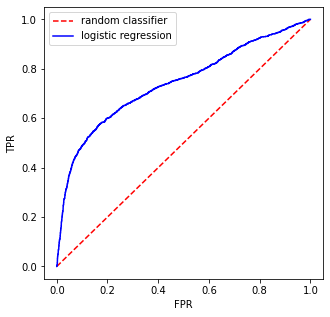

In [48]:
# logistic regression
from pyspark.ml.classification import LogisticRegression

# train the model on the train data
lr = LogisticRegression()
lrModel = lr.fit(train)

# make predictions on the test data
predictions = lrModel.transform(test)
predictions.select("prediction", "label", "features").show(5)

# using "areaUnderPR"
lgAUC = evaluator.setMetricName('areaUnderROC').evaluate(predictions)
print(f"Logistic regression: Area under ROC (AUC) = {lgAUC}")

# for plotting
import matplotlib.pyplot as plt

y_score = [float(row.probability) for row in predictions.select(vector_to_array("probability")[1].alias("probability")).collect()]
y_true = [int(row.label) for row in predictions.select("label").collect()]
fpr, tpr, thresholds = roc_curve(y_true, y_score)

plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr,
         tpr, 'blue')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(['random classifier','logistic regression'])
plt.show()

### Decision tree classifier

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       1.0|    1|(31,[0,1,2,3,4,5,...|
|       0.0|    0|(31,[0,1,2,3,4,5,...|
|       0.0|    0|(31,[0,1,2,3,4,5,...|
|       0.0|    0|(31,[0,1,2,3,4,5,...|
|       1.0|    1|(31,[0,1,2,3,4,5,...|
+----------+-----+--------------------+
only showing top 5 rows

Decision tree: Area under ROC (AUC) = 0.6664239552471668


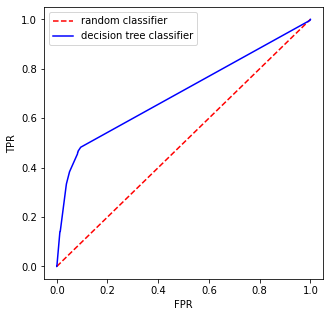

In [49]:
# decision tree classifier
from pyspark.ml.classification import DecisionTreeClassifier

# train the model on the train data
dt = DecisionTreeClassifier().setLabelCol("label").setFeaturesCol("features")
dtModel = dt.fit(train)

# make predictions on the test data
predictions = dtModel.transform(test)
predictions.select("prediction", "label", "features").show(5)

# using "areaUnderPR"
dtAUC = evaluator.setMetricName('areaUnderROC').evaluate(predictions)
print(f"Decision tree: Area under ROC (AUC) = {dtAUC}")

# for plotting
y_score = [float(row.probability) for row in predictions.select(vector_to_array("probability")[1].alias("probability")).collect()]
y_true = [int(row.label) for row in predictions.select("label").collect()]
fpr, tpr, thresholds = roc_curve(y_true, y_score)

plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr,
         tpr, 'blue')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(['random classifier','decision tree classifier'])
plt.show()

### Random forest classifier

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       1.0|    1|(31,[0,1,2,3,4,5,...|
|       0.0|    0|(31,[0,1,2,3,4,5,...|
|       0.0|    0|(31,[0,1,2,3,4,5,...|
|       0.0|    0|(31,[0,1,2,3,4,5,...|
|       1.0|    1|(31,[0,1,2,3,4,5,...|
+----------+-----+--------------------+
only showing top 5 rows

Random forest: Area under ROC (AUC) = 0.6286032753978441


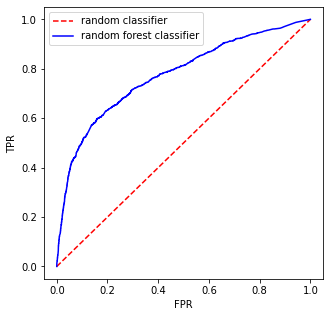

In [50]:
# random forest classifier
from pyspark.ml.classification import RandomForestClassifier

# train the model on the train data
rf = RandomForestClassifier().setLabelCol("label").setFeaturesCol("features").setNumTrees(30)
rfModel = rf.fit(train)

# make predictions on the test data
predictions = rfModel.transform(test)
predictions.select("prediction", "label", "features").show(5)

# using "areaUnderPR"
rfAUC = evaluator.setMetricName('areaUnderROC').evaluate(predictions)
print(f"Random forest: Area under ROC (AUC) = {rfAUC}")

# for plotting
y_score = [float(row.probability) for row in predictions.select(vector_to_array("probability")[1].alias("probability")).collect()]
y_true = [int(row.label) for row in predictions.select("label").collect()]
fpr, tpr, thresholds = roc_curve(y_true, y_score)

plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr,
         tpr, 'blue')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(['random classifier','random forest classifier'])
plt.show()

Comparison on AUC (`lgAUC`, `dtAUC`, `rfAUC`): a good classifier moves the ROC curve toward the top-left corner.

- Logistic regression: Area under ROC (AUC) = 0.6164525561266678
- Decision tree classifier: Area under ROC (AUC) = 0.6642971899748638
- Random forest classifier: Area under ROC (AUC) = 0.64270758037587

Using the ROC curve we can see that the Decision Tree classifier has the best performance, having a higher area under the ROC curve than the rest.

Best model choice (e.g., what are the strength and weaknesses of each of these models?)

Logistic Regression vs. Decision Tree vs. Random Forest

Pro & Cons
- Logistic Regression: Requires a large training set, Does not handle missing values, does not handle skewed classes well, best with continuous data
- Decision Tree: Easy to interpret, Fast, May overfit, Less suceptable to outliers, Best with categorical data
- Random Forest: Powerful and highly accurate, Slow, Can not be used for linear methods

## 7.4. What more would you do with this data? Anything to help you devise a better solution?

### Gradient-boosted tree classifier

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       1.0|    1|(31,[0,1,2,3,4,5,...|
|       0.0|    0|(31,[0,1,2,3,4,5,...|
|       0.0|    0|(31,[0,1,2,3,4,5,...|
|       0.0|    0|(31,[0,1,2,3,4,5,...|
|       1.0|    1|(31,[0,1,2,3,4,5,...|
+----------+-----+--------------------+
only showing top 5 rows

Gradient-boosted tree: Area under ROC (AUC) = 0.6712009792094911


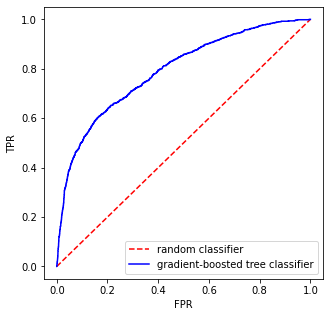

In [51]:
# gradient-boosted tree classifier

from pyspark.ml.classification import GBTClassifier

# train the model on the train data
gb = GBTClassifier().setLabelCol("label").setFeaturesCol("features").setMaxIter(30).setFeatureSubsetStrategy("auto")
gbModel = gb.fit(train)

# make predictions on the test data
predictions = gbModel.transform(test)
predictions.select("prediction", "label", "features").show(5)

# using "areaUnderPR"
gbAUC = evaluator.setMetricName('areaUnderROC').evaluate(predictions)
print(f"Gradient-boosted tree: Area under ROC (AUC) = {gbAUC}")

# for plotting
y_score = [float(row.probability) for row in predictions.select(vector_to_array("probability")[1].alias("probability")).collect()]
y_true = [int(row.label) for row in predictions.select("label").collect()]
fpr, tpr, thresholds = roc_curve(y_true, y_score)

plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr,
         tpr, 'blue')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(['random classifier','gradient-boosted tree classifier'])
plt.show()

### Hyperparameter tuning - Cross-validation

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       1.0|    1|(31,[0,1,2,3,4,5,...|
|       0.0|    0|(31,[0,1,2,3,4,5,...|
|       0.0|    0|(31,[0,1,2,3,4,5,...|
|       0.0|    0|(31,[0,1,2,3,4,5,...|
|       1.0|    1|(31,[0,1,2,3,4,5,...|
+----------+-----+--------------------+
only showing top 5 rows

Hyperparameter tuning: Area under ROC (AUC) = 0.6615156837577968


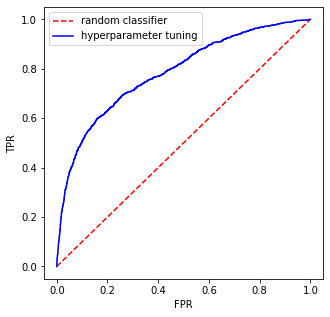

In [52]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [10, 20, 30])\
    .addGrid(rf.maxDepth, [5, 10, 15])\
    .build()

evaluator = BinaryClassificationEvaluator().setRawPredictionCol("prediction").setLabelCol("label")
cv = CrossValidator()\
    .setEstimator(rf)\
    .setEvaluator(evaluator)\
    .setEstimatorParamMaps(paramGrid)\
    .setNumFolds(3)

cvModel = cv.fit(train)

predictions = cvModel.transform(test)
predictions.select("prediction", "label", "features").show(5)

# using "areaUnderPR"
hptAUC = evaluator.setMetricName('areaUnderROC').evaluate(predictions)
print(f"Hyperparameter tuning: Area under ROC (AUC) = {hptAUC}")

# for plotting
y_score = [float(row.probability) for row in predictions.select(vector_to_array("probability")[1].alias("probability")).collect()]
y_true = [int(row.label) for row in predictions.select("label").collect()]
fpr, tpr, thresholds = roc_curve(y_true, y_score)

plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr,
         tpr, 'blue')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(['random classifier','hyperparameter tuning'])
plt.show()